### Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

### Function to get Stock Data using yfinance

In [2]:
# Define a function to get data given a list of tickers and clean the data
def get_tickers(filepath, start_date = "2017-01-01"):
    tickers = []
    with open(filepath) as file:
        for line in file:
            tickers.append(line.strip())
    data = yf.download(tickers, start = start_date).sort_index()['Adj Close']
    clean_data = data[data.isna().sum(axis = 1) != data.shape[1]]
    clean_data = clean_data.dropna(axis = 1)
    return clean_data

### Function to get Least volatile stocks given a dataframe with Adjusted Close prices of multiple Stocks

In [3]:
# Define a function to get the n% least volatile stocks in a DataFrame over the past t months
def get_n_least_volatile(stock_data, date, t = 36, n = 10):
    date = pd.to_datetime(date)
    start_date = date - pd.DateOffset(months=t)
    data = stock_data.copy()[start_date:date]
    ticker_vols = dict()
    for ticker in data.columns:
        return_df = np.array(data[ticker].pct_change(periods=5))[5:]
        vol = return_df.std()
        ticker_vols[ticker] = vol
    sorted_tickers = sorted(ticker_vols.items(), key = lambda x: x[1])
    return [x[0] for x in sorted_tickers[:n]]


### Function to construct a portfolio with the Tickers as columns where the value for each cell is the percentage of the portfolio that we are allocating to that specific ticker at a specific day

In [4]:
def construct_portfolio(stock_data, start_date = "2021-01-01", end_date = "2023-12-15", percentage_of_all_stocks_to_buy = 0.1):
    portfolio = pd.DataFrame(data = np.zeros([len(stock_data),len(stock_data.columns)]), index = stock_data.index, columns=stock_data.columns)
    num_stocks = int(stock_data.shape[1] // (1 / percentage_of_all_stocks_to_buy))
    weight = 1 / num_stocks
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    current_month = start_date.month - 1
    for date in stock_data[start_date : end_date].index:
        if date.month != current_month:
            stocks_in_portfolio = get_n_least_volatile(stock_data = stock_data, date = date, n = num_stocks)
            current_month = date.month
        for ticker in stocks_in_portfolio:
            portfolio.loc[date, ticker] = weight
    return portfolio[start_date : end_date]
        

### Function to backtest strategy results and compare it to the index from which the least volatile stocks were picked

In [5]:
def backtest(stock_data, portfolio, index, start_date = "2021-01-01", end_date = "2023-12-15"):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    returns = pd.DataFrame(index = portfolio.index)
    return_df = (stock_data).pct_change().shift(-1)[start_date : end_date].dropna()
    returns["daily_returns"] = (return_df * portfolio).sum(axis=1)
    returns["cumulative_returns"] = (returns["daily_returns"] + 1).cumprod() - 1
    returns["cumulative_%_returns"] = (returns["cumulative_returns"]) * 100
    returns['index_returns'] = index.pct_change().shift(-1)
    returns["index_cumulative_returns"] = (returns["index_returns"] + 1).cumprod() - 1
    returns["index_cumulative_%_returns"] = (returns["index_cumulative_returns"]) * 100
    return returns


### Functions to Plot the Strategy and Index returns and drawdowns and function to display Sharpe and max Drawdown of each

In [6]:
# Function to Calculate Drawdowns
def calculate_drawdown(cumulative_returns):
    cumulative_returns = cumulative_returns.copy()
    cumulative_returns += 1
    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    running_max[running_max < 1] = 1
    drawdown = (cumulative_returns / running_max - 1) * 100
    return drawdown.min(), drawdown

# Function to Plot Returns
def plot_returns(returns):
    plt.figure(figsize=(12, 6))
    plt.plot(returns['cumulative_%_returns'], label='Cumulative % Returns of the Least Volatile Stocks', color='forestgreen', linewidth=2, linestyle='-')
    plt.plot(returns['index_cumulative_%_returns'], label='Cumulative % Returns of Index', color='firebrick', linewidth=2, linestyle='-')
    plt.title('Cumulative Strategy Returns vs Cumulative Index Returns', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    _, drawdown_1 = calculate_drawdown(returns['cumulative_returns'])
    _, drawdown_2 = calculate_drawdown(returns['index_cumulative_returns'])
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Drawdown plot for strategy
    ax.plot(drawdown_1.index, drawdown_1.values, color='forestgreen', label='Drawdown of the Least Volatile Stocks')
    ax.fill_between(drawdown_1.index, drawdown_1.values, color='forestgreen', alpha=0.3)

    # Drawdown plot for index returns
    ax.plot(drawdown_2.index, drawdown_2.values, color='firebrick', label='Drawdown of Index')
    ax.fill_between(drawdown_2.index, drawdown_2.values, color='firebrick', alpha=0.3)

    
    # Setting title, labels, and grid
    ax.set_title('Comparison of Drawdowns', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Drawdown(%)', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()


def print_metrics(returns):
    sharpe1 = round(returns['daily_returns'].mean() / returns['daily_returns'].std() * np.sqrt(252), 2)
    sharpe2 = round(returns['index_returns'].mean() / returns['index_returns'].std() * np.sqrt(252), 2)
    drawdown_1, _ = calculate_drawdown(returns['cumulative_returns'])
    drawdown_2, _ = calculate_drawdown(returns['index_cumulative_returns'])
    drawdown_1 = round(drawdown_1, 2)
    drawdown_2 = round(drawdown_2, 2)

    table = f"""
            <table style='font-size: 20px;'>
                <tr>
                    <th></th>
                    <th>Sharpe Ratio</th>
                    <th>Max Drawdown</th>
                </tr>
                <tr>
                    <td>Least Volatile Stocks</td>
                    <td>{sharpe1}</td>
                    <td>{drawdown_1}</td>
                </tr>
                <tr>
                    <td>Index</td>
                    <td>{sharpe2}</td>
                    <td>{drawdown_2}</td>
                </tr>
            </table>
            """

    return display(HTML(table))

# Getting the Data

In [7]:
# Get the Data
filepath = './russell2000.txt'
index_ticker = "IWM"
stock_data = get_tickers(filepath)

[*********************100%***********************]  1783 of 1783 completed

42 Failed downloads:
- ISEE: No data found, symbol may be delisted
- HMPT: No data found, symbol may be delisted
- AMRS: No data found, symbol may be delisted
- FOCS: No data found, symbol may be delisted
- QUOT: No data found, symbol may be delisted
- KLR: No data found, symbol may be delisted
- AJRD: No data found, symbol may be delisted
- DICE: No data found, symbol may be delisted
- ZEV: No data found, symbol may be delisted
- RIDE: No data found, symbol may be delisted
- RETA: No data found, symbol may be delisted
- GRNA: No data found, symbol may be delisted
- CELL: No data found, symbol may be delisted
- PRDS: No data found, symbol may be delisted
- ENOB: No data found, symbol may be delisted
- CVT: No data found, symbol may be delisted
- TFM: No data found for this date range, symbol may be delisted
- CIR: No data found, symbol may be delisted
- INDT: No data found, symbol may be delisted
- TRTN: No dat

# Running the Strategy

[*********************100%***********************]  1 of 1 completed


,Sharpe Ratio,Max Drawdown
Least Volatile Stocks,0.48,-18.04
Index,0.14,-33.13


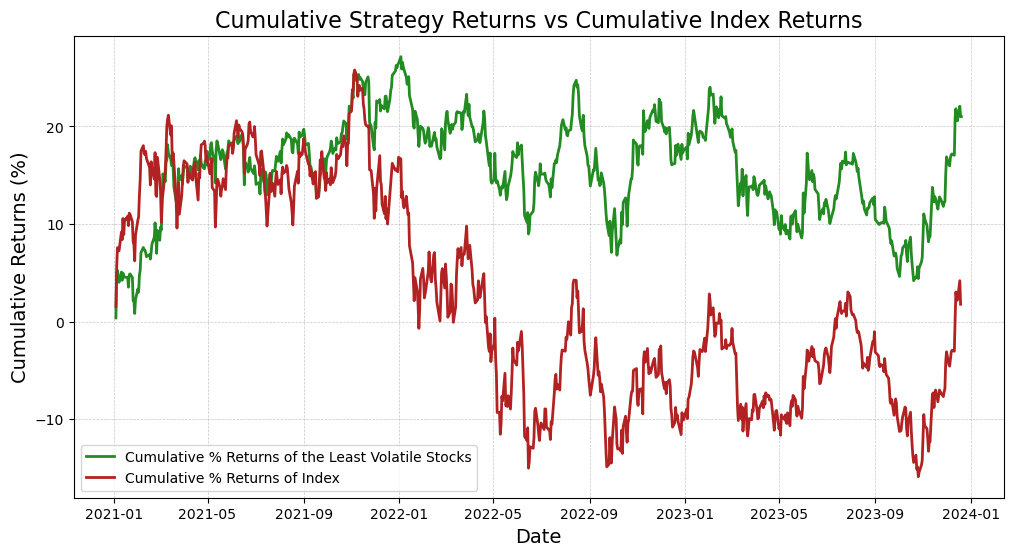

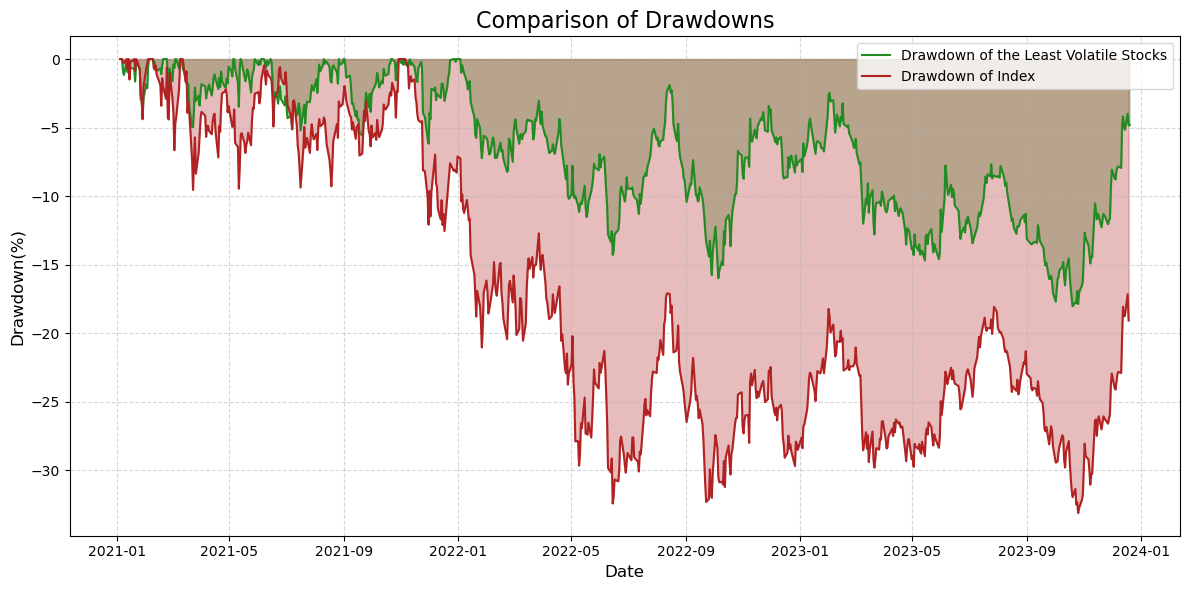

In [8]:
# Run the strategy
start_date = "2021-01-01"
end_date = "2024-01-01"
index = yf.download(index_ticker, start_date, end_date)['Adj Close']
portfolio = construct_portfolio(stock_data, start_date = start_date, end_date = end_date, percentage_of_all_stocks_to_buy = 0.1)
returns = backtest(stock_data, portfolio, index, start_date = start_date, end_date = end_date)
print_metrics(returns)
plot_returns(returns)